In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

## Load Features and Visualize

In [3]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [4]:
### load subjects

def load_all_subj_features(feature_name):
    # load all valid subjects
    all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
    all_subjs = [subj for subj in all_subjs if subj.isdigit()]
    all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

    # load all features
    all_features = []
    all_dfs = []
    settings = None
    for subj in all_subjs:
        feature_path = os.path.join(
            DEFAULT_FEATURE_FOLDER, subj, feature_name, 'features.npy')
        subj_features = np.load(feature_path)
        all_features.append(subj_features)
        subj_df_path = os.path.join(
            DEFAULT_FEATURE_FOLDER, subj, 'behavior.csv') 
        subj_df = pd.read_csv(subj_df_path, index_col=0)
        all_dfs.append(subj_df)

        # load settings
        if settings is None:
            settings_path = os.path.join(
                DEFAULT_FEATURE_FOLDER, subj, feature_name, 'settings.json')
            with open(settings_path, 'r') as f:
                settings = json.load(f)

    all_features = np.concatenate(all_features, axis=0)
    all_dfs = pd.concat(all_dfs, ignore_index=True)
    return all_features, all_dfs, settings


In [5]:
def abs_angle_diff(x1, x2):
    d1 = np.abs(x1 - x2)
    d2 = 180 - d1
    ds = np.min([d1, d2], axis=0)
    return ds

def divide_by_condition(nbins, subj_features, subj_dfs, stim_ids, time_phases):
    # slice time phase
    subj_features = subj_features[:, time_phases, ...]

    # create pattern according to stim
    angle_bins = (180 / nbins) * (np.arange(nbins) + 0.5)
    project_ids = []
    for stim_id in stim_ids:
        map_id = np.argmin(abs_angle_diff(
            subj_dfs[stim_id].to_numpy()[:, None], angle_bins[None, :]), axis=1)
        project_ids.append(map_id)
    project_ids = np.array(project_ids).T

    bin_patterns = np.zeros((nbins,)+ ((subj_features.shape)[2:]))
    for bin_id in range(nbins):
        mask = (project_ids == bin_id).any(axis=1)
        bin_patterns[bin_id] = np.mean(subj_features[mask], axis=(0, 1))
    
    return bin_patterns, angle_bins

In [6]:
N_BINS = 9

In [7]:
ISI_TIME = [2250, 3250]
DELAY_TIME = [4500, 9500]

### Check Mean Gaze Locations

In [8]:
mean_gaze_features, all_df, settings = load_all_subj_features('GazeMeanExtractor_297c84')

In [9]:
def plot_mean_gaze(mean_gaze_patterns, angles, ax):
    # flip y
    mean_gaze_patterns = mean_gaze_patterns.copy()
    mean_gaze_patterns[:, 1] = -mean_gaze_patterns[:, 1]

    n_bins = len(mean_gaze_patterns)
    bar_length = 0.1
    for i in range(n_bins):
        angle = np.pi/2 - np.radians(angles[i])
        dx = bar_length * np.cos(angle)
        dy = bar_length * np.sin(angle)
        ax.plot(
            [mean_gaze_patterns[i, 0] - dx/2, 
             mean_gaze_patterns[i, 0] + dx/2], 
            [mean_gaze_patterns[i, 1] - dy/2, 
             mean_gaze_patterns[i, 1] + dy/2], 
            'k-', lw=10)
        
    # scatter plot the locations
    ax.scatter(
        mean_gaze_patterns[:, 0], mean_gaze_patterns[:, 1], 
        s=100, c='coral', zorder=2)
        
    center = [0, 0] # np.mean(mean_gaze_patterns, axis=0)
    ax.scatter(center[0], center[1], s=100, c='gray')
    ax.set_xlim(center[0] - 1, center[0] + 1)
    ax.set_ylim(center[1] - 1, center[1] + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

#### the inter-stim-interval pattern

In [10]:
timebin = settings['time_binning']['timebin_size']
isi_time_points = np.arange(
    np.ceil(ISI_TIME[0] / timebin + 0.5),
    np.floor(ISI_TIME[1] / timebin - 0.5) + 1).astype(int)

In [11]:
isi_valid_mask = (
    (all_df['trial_code'] == 1) |
    (all_df['stim_1_to_report'])
).to_numpy()
mean_gaze_isi_patterns, angle_bins = divide_by_condition(
    nbins=N_BINS, subj_features=mean_gaze_features[isi_valid_mask], 
    subj_dfs=all_df[isi_valid_mask], 
    stim_ids=['stim_1',], time_phases=isi_time_points)

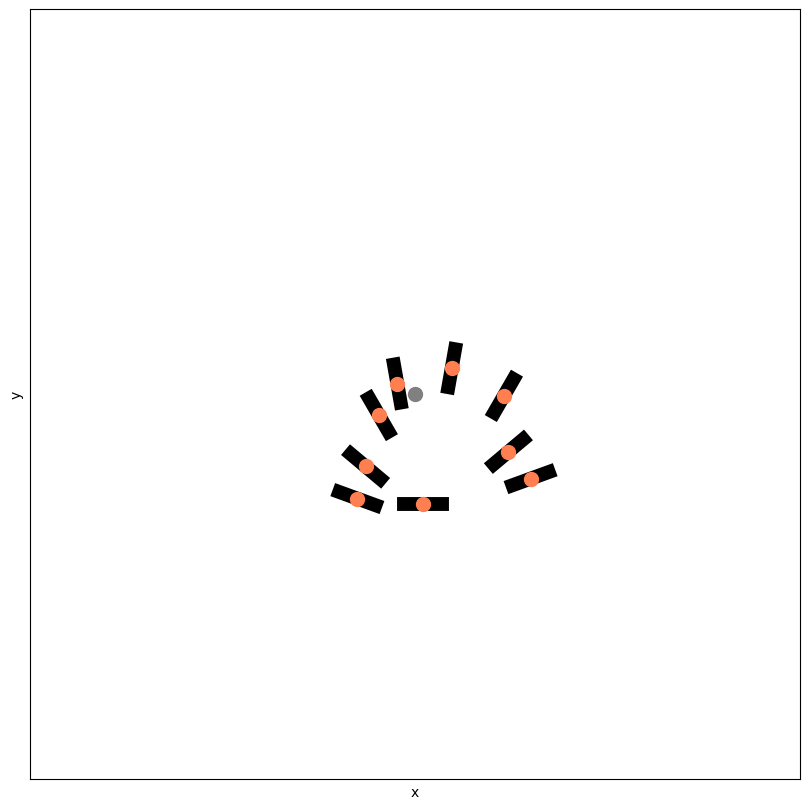

In [12]:
mean_gaze_plot_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'gaze_features', 'isi_mean.png')

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_mean_gaze(mean_gaze_isi_patterns, angle_bins, ax)
plt.savefig(mean_gaze_plot_path)


#### The delay mean gaze

In [13]:
delay_time_points = np.arange(
    np.ceil(DELAY_TIME[0] / timebin + 0.5),
    np.floor(DELAY_TIME[1] / timebin - 0.5) + 1).astype(int)

n_delay_phases = 3
delay_time_points = np.array_split(delay_time_points, n_delay_phases)

In [14]:
stim1_only_mask = (
    (all_df['trial_code'] == 0) &
    (all_df['stim_1_to_report']) &
    (~all_df['stim_2_to_report'])
).to_numpy()
stim2_only_mask = (
    (all_df['trial_code'] == 0) &
    (~all_df['stim_1_to_report']) &
    (all_df['stim_2_to_report'])
).to_numpy()
stim_both_mask = (
    (all_df['trial_code'] == 1) |
    ((all_df['trial_code'] == 0) &
    (all_df['stim_1_to_report']) &
    (all_df['stim_2_to_report']))
).to_numpy()

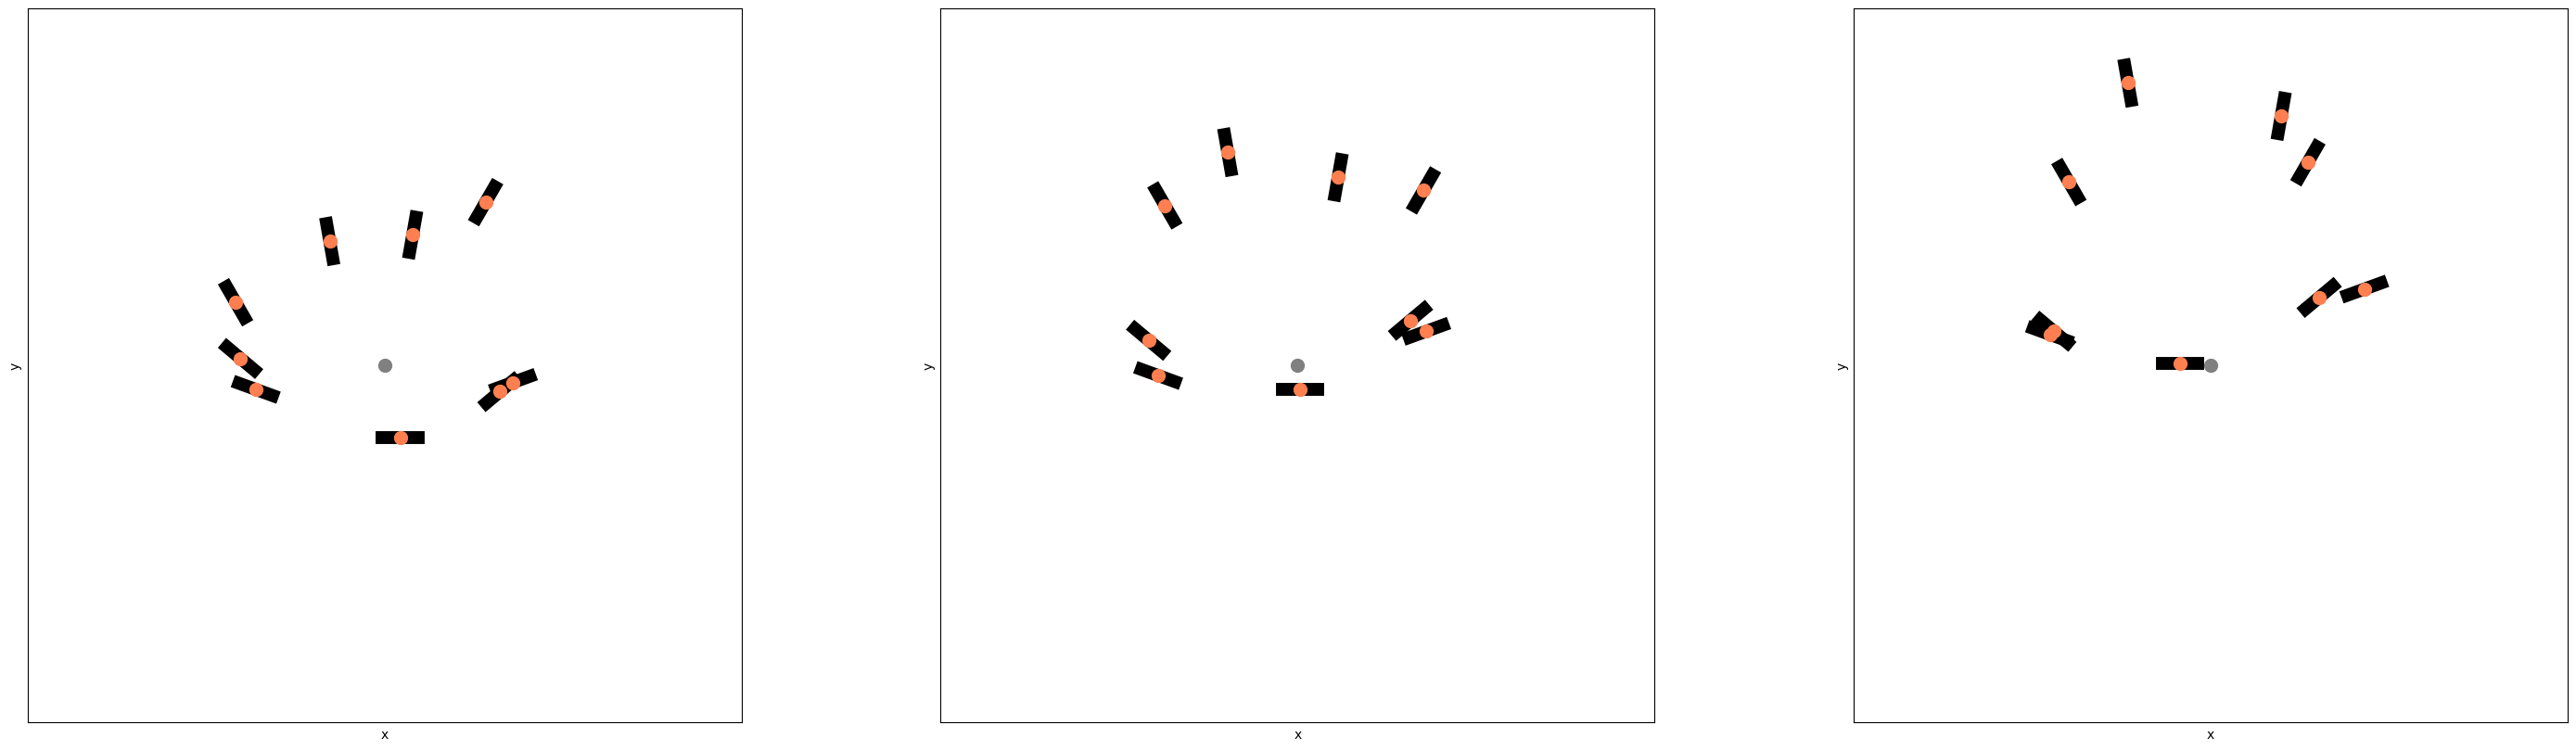

In [15]:
# the development of mean gaze patterns
fig, axs = plt.subplots(1, n_delay_phases, 
    figsize = (12 * n_delay_phases, 10))

for delay_phase_id, delay_phase in enumerate(delay_time_points):
    mean_gaze_stim1_only_delay_patterns, _ = divide_by_condition(
        nbins=N_BINS, subj_features=mean_gaze_features[stim1_only_mask], 
        subj_dfs=all_df[stim1_only_mask], 
        stim_ids=['stim_1',], time_phases=delay_phase)
    mean_gaze_stim2_only_delay_patterns, _ = divide_by_condition(
        nbins=N_BINS, subj_features=mean_gaze_features[stim2_only_mask], 
        subj_dfs=all_df[stim2_only_mask], 
        stim_ids=['stim_2',], time_phases=delay_phase)
    mean_gaze_delay_only1 = (
        mean_gaze_stim1_only_delay_patterns + mean_gaze_stim2_only_delay_patterns) / 2
    plot_mean_gaze(mean_gaze_delay_only1, angle_bins, axs[delay_phase_id])

mean_gaze_delay_plot_only1_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'gaze_features', 'delay_mean_only1.png')
plt.savefig(mean_gaze_delay_plot_only1_path)

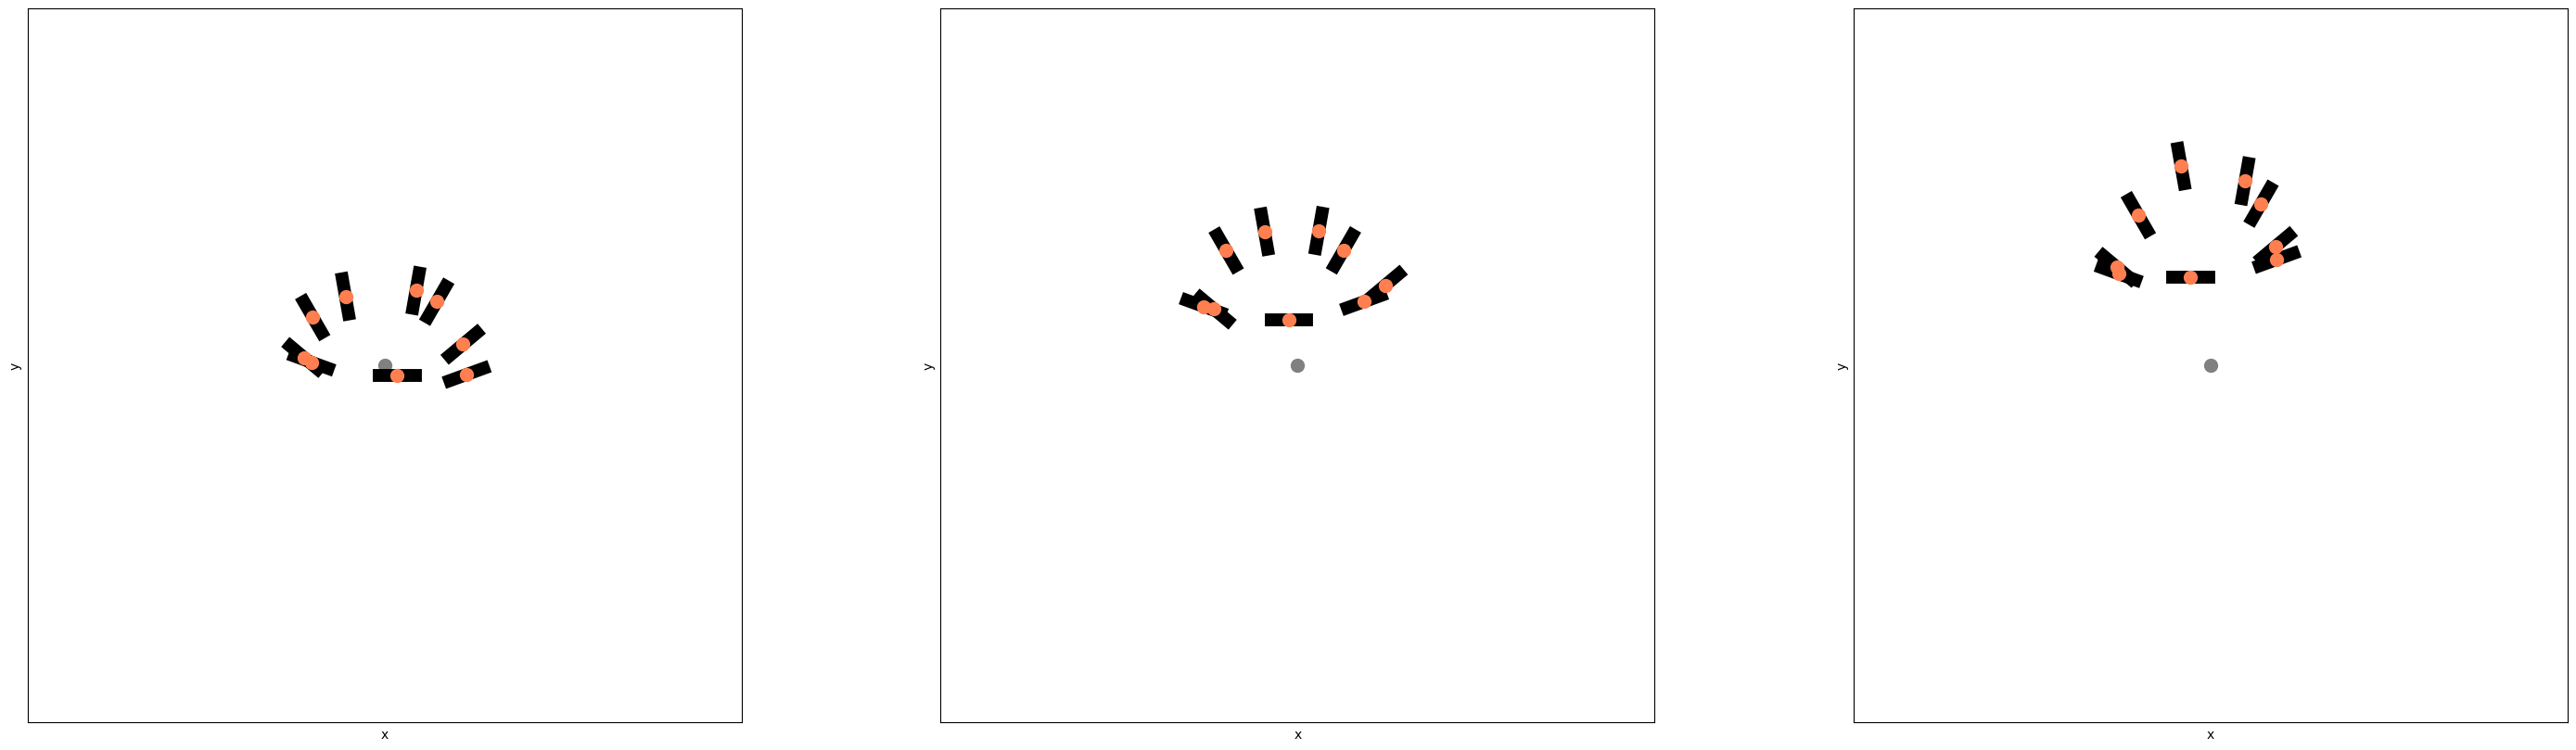

In [16]:
# the development of mean gaze patterns
fig, axs = plt.subplots(1, n_delay_phases, 
    figsize = (12 * n_delay_phases, 10))

for delay_phase_id, delay_phase in enumerate(delay_time_points):
    mean_gaze_stim1_delay_patterns, _ = divide_by_condition(
        nbins=N_BINS, 
        subj_features=mean_gaze_features[stim1_only_mask|stim_both_mask], 
        subj_dfs=all_df[stim1_only_mask|stim_both_mask], 
        stim_ids=['stim_1',], time_phases=delay_phase)
    mean_gaze_stim2_delay_patterns, _ = divide_by_condition(
        nbins=N_BINS, 
        subj_features=mean_gaze_features[stim2_only_mask|stim_both_mask], 
        subj_dfs=all_df[stim2_only_mask|stim_both_mask], 
        stim_ids=['stim_2',], time_phases=delay_phase)
    mean_gaze_delay = (
        mean_gaze_stim1_delay_patterns + mean_gaze_stim2_delay_patterns) / 2
    plot_mean_gaze(mean_gaze_delay, angle_bins, axs[delay_phase_id])

mean_gaze_delay_plot_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'gaze_features', 'delay_mean.png')
plt.savefig(mean_gaze_delay_plot_path)

### 1d distribution of angles

In [17]:
d1_gaze_features, all_df, settings = load_all_subj_features('GazeAngleFeatureExtractor_184492')

In [18]:
from matplotlib.patches import Wedge
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_single_1d_gaze(d1_gaze_pattern, angle, ax):
    norm_values = d1_gaze_pattern / np.max(np.abs(d1_gaze_pattern))
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.bwr
    n_bins = len(d1_gaze_pattern)
    angle_step = 360 / n_bins
    for i in range(n_bins):
        end_angle = (90-(i * angle_step)) % 360
        start_angle = (90-((i+1) * angle_step)) % 360
        color = cmap(norm(norm_values[i]))
        wedge = Wedge((0, 0), 1, start_angle, end_angle, color=color)
        ax.add_patch(wedge)

    # plot the grating bar
    bar_length = 0.6
    bar_rad = np.radians(90 - angle)
    ax.plot(
        [-np.cos(bar_rad)*bar_length, np.cos(bar_rad)*bar_length],
        [-np.sin(bar_rad)*bar_length, np.sin(bar_rad)*bar_length],
        'k-', lw=10)
    
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')


In [19]:
def plot_1d_gaze(d1_gaze_patterns, angles, axs):
    n_bins = len(d1_gaze_patterns)
    for i in range(n_bins):
        plot_single_1d_gaze(d1_gaze_patterns[i], angles[i], axs[i])

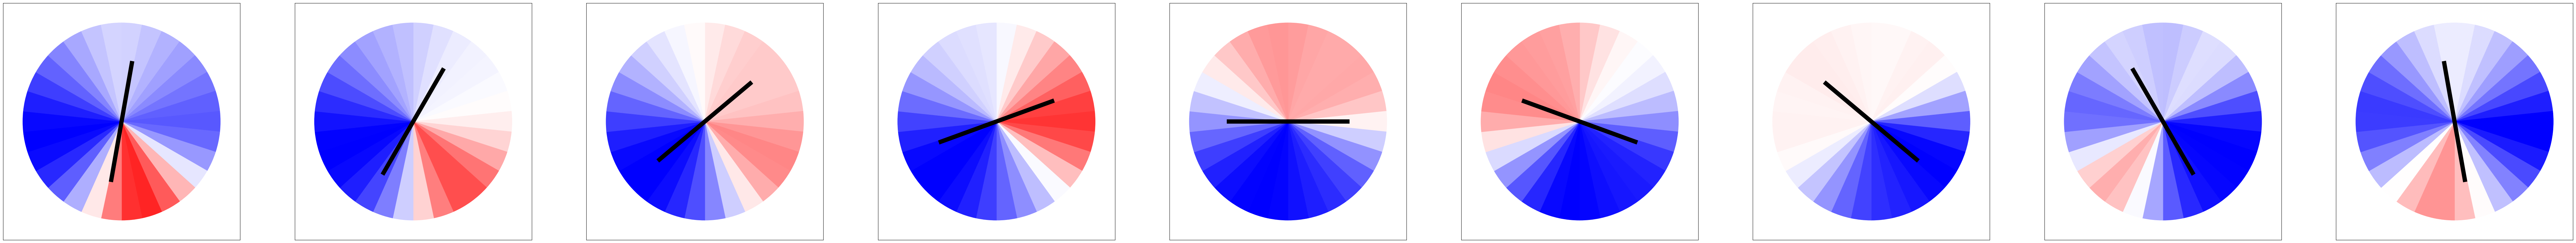

In [20]:
d1_gaze_isi_patterns, angle_bins = divide_by_condition(
    nbins=N_BINS, subj_features=d1_gaze_features[isi_valid_mask], 
    subj_dfs=all_df[isi_valid_mask], 
    stim_ids=['stim_1',], time_phases=isi_time_points)

d1_gaze_plot_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'gaze_features', 'isi_1d.png')
fig, axs = plt.subplots(1, N_BINS, figsize = (12*N_BINS, 10))
plot_1d_gaze(d1_gaze_isi_patterns, angle_bins, axs)
plt.savefig(d1_gaze_plot_path)
